# Dependencies

In [ ]:
import pandas as pd
import cleantext
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# Data cleaning and structuring

### Loading the data

In [246]:
df = pd.read_csv('first_10000_rows.csv')
print(df['content'].head(5))

0    Life is an illusion, at least on a quantum lev...
1    Unfortunately, he hasn’t yet attacked her for ...
2    The Los Angeles Police Department has been den...
3    The White House has decided to quietly withdra...
4    “The time has come to cut off the tongues of t...
Name: content, dtype: object


### cleaning med clean

In [247]:
df['content'] = df['content'].apply(lambda x: cleantext.clean(text=x))
print(df['content'].head(5))

0    life illus least quantum level theori recent c...
1    unfortun hasn’t yet attack islam terrorismconn...
2    lo angel polic depart deni million feder aid l...
3    white hous decid quietli withdraw tie ramallah...
4    “the time come cut tongu support peac mourn it...
Name: content, dtype: object


### cleaning med clean_words

In [248]:
df['content'] = df['content'].apply(lambda x: cleantext.clean_words(
    text=x,
    clean_all=True,
    extra_spaces=True,
    stemming=True,
    stopwords=True,
    stp_lang='english',
))

print(df['content'].head(5))

0    [life, illu, least, quantum, level, theori, re...
1    [unfortun, hasn’t, yet, attack, islam, terrori...
2    [lo, angel, polic, depart, deni, million, fede...
3    [white, hou, decid, quietli, withdraw, tie, ra...
4    [“the, time, come, cut, tongu, support, peac, ...
Name: content, dtype: object


### Export

In [249]:
df.to_csv('data_cleaned.csv')

# Categorization and splitting

In [ ]:
temp = [] 
categories = set()  
convert = {
    '': "skip", 'conspiracy': 'fake', 'satire': 'fake', 'reliable': 'reliable',
    'unreliable': 'fake', 'junksci': 'fake', 'unknown': 'skip',
    'political': 'reliable', 'fake': 'fake', 'hate': 'fake',
    'clickbait': 'reliable', 'bias': 'reliable', 'rumor': 'fake'
}

fakeCount = 0 
realCount = 0 

with open("data_cleaned.csv", "r") as src: 
    reader = csv.reader(src) 
    header = next(reader) 
    
    for row in reader:  
        content = row[4]  # Extract category from the fourth column
        categories.add(content)  # Store the unique category
        
        row[4] = convert[row[4]]  # Convert category using the dictionary
        
        if row[4] == "fake":
            fakeCount += 1  # Increment fake count
        elif row[4] == "reliable":
            realCount += 1  # Increment real count
        
        if row[4] != "skip":  # Skip unwanted categories
            temp.append(row)  # Append valid rows to the list

# Create a DataFrame from the filtered list, keeping the original column names
df = pd.DataFrame(temp, columns=header)

# Save the processed data to a new CSV file without renaming columns
df.to_csv('data_cleaned_fr.csv', index=False)

# Print the ratio of fake vs. real news articles and number of articles
print(f"Number of articles left: {len(temp)}")
print(f"Reliable articles: {realCount}")
print(f"Fake articles: {fakeCount}")
print(f"Ratio of fakes: {fakeCount/(fakeCount+realCount)}")
print(f"Ratio of reliable: {realCount/(fakeCount+realCount)}")

Number of articles left: 9891
Reliable articles: 1484
Fake articles: 8407
Ratio of fakes: 0.8499646142958245
Ratio of reliable: 0.15003538570417552


In [251]:
train_data = pd.read_csv("data_cleaned_fr.csv")

### Splitting

In [252]:
X = train_data['content']
y = train_data['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Vectorization

In [253]:
vectorizer = CountVectorizer(stop_words='english', max_features=10000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print("Original training class distribution:")
print(y_train.value_counts())

Original training class distribution:
type
fake        6725
reliable    1187
Name: count, dtype: int64


### Over sampling

In [254]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vectorized, y_train)
print("Resampled training class distribution:")
print(pd.Series(y_train_resampled).value_counts())

Resampled training class distribution:
type
fake        6725
reliable    6725
Name: count, dtype: int64


# Training and evaluation

### Model training

In [255]:
classifier = MultinomialNB()
classifier.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

In [256]:
y_pred = classifier.predict(X_train_resampled)
print(f"Accuracy: {accuracy_score(y_train_resampled, y_pred)}")
print(classification_report(y_train_resampled, y_pred))

Accuracy: 0.9086988847583644
              precision    recall  f1-score   support

        fake       0.91      0.91      0.91      6725
    reliable       0.91      0.91      0.91      6725

    accuracy                           0.91     13450
   macro avg       0.91      0.91      0.91     13450
weighted avg       0.91      0.91      0.91     13450



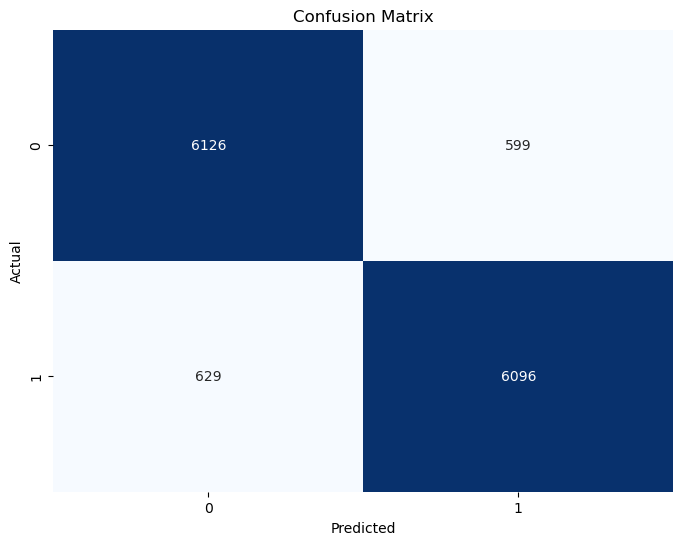

In [257]:
cm = confusion_matrix(y_train_resampled, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Evaluation

In [258]:
y_pred = classifier.predict(X_test_vectorized)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8832743810005053
              precision    recall  f1-score   support

        fake       0.97      0.89      0.93      1682
    reliable       0.58      0.82      0.68       297

    accuracy                           0.88      1979
   macro avg       0.77      0.86      0.80      1979
weighted avg       0.91      0.88      0.89      1979



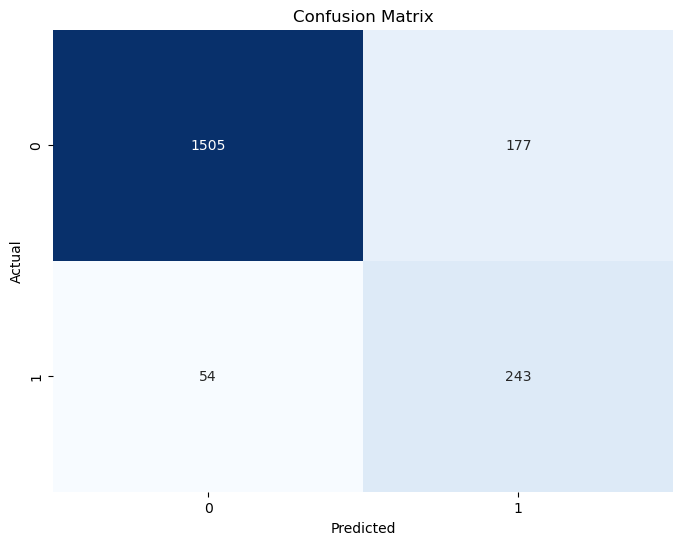

In [259]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()